# Airbnb Algorithm Challenge Report

The challenge is to predict whether a listing will be booked (dim_is_requested) 30 days later.  And here we’ve got 125k records consisting of 45 features, collected in the year of 2015. As the dataset is not that large, there is no need for distributed computing. I will just work through the general modeling process on my laptop, with tools: 

- [XGBoost](https://github.com/dmlc/xgboost)
- [scikit-learn 0.20](http://scikit-learn.org/dev/index.html)

## Data Exploration
I’d like to explore the dataset before handing on experiment, to exclude those abnormalities and make data cleaner. The abnormalities include dupes, noises and outliers, etc.

### Dupes
First of all, let's remove 131 duplicated records.

In [1]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv('TH_data_challenge.tsv', sep='\t')
df.duplicated(keep='first').sum()
df = df.drop_duplicates(keep='first')

### Noises
Noises in this case can be contrary labels with similar features, but there seems no such record in this dataset.

In [2]:
df_no_noises = df.drop(columns =['dim_is_requested'])
df_no_noises.duplicated(keep='first').sum()

0

### Outliers

Most outliers are normaly due to system issues. Such as: price is abnormally low (<= 0):

In [3]:
p_check = [.0001,.10, .25, .5, .75, .9 , .9999]
df.describe(percentiles = p_check)
# I assume kdt_n exclude itself
df_no_outliers = df[(df.m_effective_daily_price > 0)]
df_no_outliers.describe(percentiles = p_check)

,m_effective_daily_price,m_pricing_cleaning_fee,dim_lat,dim_lng,dim_person_capacity,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,...,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
count,184086.000000,184086.000000,184086.000000,184086.000000,184086.000000,183899.000000,183899.000000,146333.000000,184086.000000,170175.000000,...,184086.000000,184086.000000,184086.000000,184086.000000,184085.000000,184085.000000,184085.000000,184085.000000,184069.000000,171130.000000
mean,149.497835,38.035943,43.552902,-44.264007,3.265952,18.473613,10.979075,69.202381,4.154743,0.562027,...,91.597895,0.973107,18555.870006,1.067698,2.098329,90.223679,45.649189,109.225206,115.375352,95.582751
std,272.345131,50.003168,6.817416,59.183739,2.009910,32.318123,20.026387,123.562999,0.816426,0.306809,...,48.609062,0.071513,9099.360406,0.523169,2.081747,75.809958,37.513264,64.010527,72.718040,48.724038
min,0.043935,0.000000,33.708763,-122.510925,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,13.142857,0.571429,1028.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0.01%,0.045791,0.000000,33.708763,-122.510380,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,13.142857,0.571429,1064.000000,0.000000,0.000000,1.000000,1.000000,16.432791,15.921237,14.798372
10%,51.156967,0.000000,34.039494,-118.603200,2.000000,0.000000,0.000000,1.000000,3.000000,0.119119,...,37.142857,0.857143,7681.000000,0.416667,0.346939,21.000000,12.000000,56.020839,59.000000,49.000000
25%,71.386212,0.000000,34.129005,-118.357056,2.000000,1.000000,0.000000,5.000000,3.000000,0.300549,...,56.000000,1.000000,9690.000000,0.666667,0.857143,48.000000,25.000000,75.000000,77.743820,65.000000
50%,100.000000,25.000000,48.845016,2.303334,2.000000,6.000000,3.000000,20.000000,4.000000,0.577921,...,83.142857,1.000000,21027.000000,1.037037,1.632653,86.000000,41.000000,95.275607,98.550440,86.058520
75%,152.468910,53.947735,48.871037,2.355691,4.000000,22.000000,12.000000,72.000000,5.000000,0.853429,...,116.714286,1.000000,24867.000000,1.396372,2.717687,113.000000,56.000000,129.000000,135.459811,115.719597
90%,250.000000,100.000000,48.887280,2.384931,6.000000,53.000000,31.000000,197.000000,5.000000,0.960145,...,161.571429,1.000000,28648.000000,1.785714,4.134354,141.000000,73.000000,172.500000,182.031751,150.000000


## Preprocessing
In preprocessing, I need to encode categorical features, drop/fill empty values, split the dataset to training and validation sets, etc. However since I used XGBoost, there is not need dealing with missing values and normalizing dataset.

### Raw Features List
Thanks to neural net, I can use as many features as possible:

```
1. m_effective_daily_price [continuous]
2. m_pricing_cleaning_fee [continuous]
3. dim_market [categorical]
4. dim_room_type [categorical]
5. dim_person_capacity [discrete]
6. dim_is_instant_bookable [nominal]
7. m_checkouts [discrete]
8. m_reviews [discrete]
9. days_since_last_booking [discrete]
10. cancel_policy [categorical]
11. image_quality_score [continuous]
12. m_total_overall_rating [discrete]
13. m_professional_pictures [discrete]
14. dim_has_wireless_internet [nominal]
15. ds_night_day_of_week [discrete]
16. ds_night_day_of_year [discrete]
17. ds_checkin_gap [discrete]
18. ds_checkout_gap [discrete]
19. occ_occupancy_plus_minus_7_ds_night [continuous]
20. occ_occupancy_plus_minus_14_ds_night [continuous]
21. occ_occupancy_trailing_90_ds [continuous]
22. m_minimum_nights [discrete]
23. m_maximum_nights [discrete]
24. price_booked_most_recent [continuous]
25. p2_p3_click_through_score [continuous]
26. p3_inquiry_score [continuous]
27. listing_m_listing_views_2_6_ds_night_decay [discrete]
28. general_market_m_unique_searchers_0_6_ds_night [discrete]
29. general_market_m_contacts_0_6_ds_night [discrete]
30. general_market_m_reservation_requests_0_6_ds_night [discrete]
31. general_market_m_is_booked_0_6_ds_night [discrete]
32. m_available_listings_ds_night [discrete]
33. kdt_score [continuous]
34. r_kdt_listing_views_0_6_avg_n100 [discrete]
35. r_kdt_n_active_n100 [discrete]
36. r_kdt_n_available_n100 [discrete]
37. r_kdt_m_effective_daily_price_n100_p50 [continuous]
38. r_kdt_m_effective_daily_price_available_n100_p50 [continuous]
39. r_kdt_m_effective_daily_price_booked_n100_p50 [continuous]
```

### NULL
This is about whether to drop those records with null or fill them with certain values. Here I actually have no need to do anything since XGB will handle those missing values. :)

In [4]:
df_select = df_no_outliers.drop(columns=['ds_night',
                                           'ds',
                                           'id_listing_anon',
                                           'id_user_anon',
                                           'dim_lat',
                                           'dim_lng'])  

### Categorical Features
Encoding string- or integer- like categorical features:

In [5]:
from sklearn.preprocessing import CategoricalEncoder, RobustScaler, StandardScaler

enc = CategoricalEncoder(encoding='ordinal')
encoded_features = enc.fit_transform(df_select[['dim_is_requested','dim_market','dim_room_type','cancel_policy','dim_is_instant_bookable']])
encoded_df = pd.DataFrame(encoded_features, index=df_select.index, columns=['dim_is_requested','dim_market','dim_room_type','cancel_policy','dim_is_instant_bookable'])
encoded_df.head(2)

,dim_is_requested,dim_market,dim_room_type,cancel_policy,dim_is_instant_bookable
0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0


In [6]:
col = df_select.columns.tolist()
col = col[1:3] + col[5:6] + col[7:10] + col[11:]
col_cat = encoded_df.columns.tolist()
col_full = col_cat[:] + col[:]
df = df_select[col]

stack_full = np.column_stack([encoded_df, df])
stack_df = pd.DataFrame(stack_full, index=df_select.index, columns=col_full)
stack_df.head(2)

,dim_is_requested,dim_market,dim_room_type,cancel_policy,dim_is_instant_bookable,m_effective_daily_price,m_pricing_cleaning_fee,dim_person_capacity,m_checkouts,m_reviews,...,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
0,0.0,0.0,1.0,1.0,0.0,110.0,60.0,2.0,24.0,19.0,...,41.428571,1.0,9840.0,1.314286,1.795918,57.0,48.0,79.0,75.0,98.0
1,1.0,0.0,1.0,0.0,1.0,70.0,0.0,2.0,105.0,55.0,...,51.714286,1.0,9599.0,0.535714,2.693878,49.0,36.0,65.0,65.0,42.0


### Split
After above transformations, we can split samples into training/test sets. And standardization is an important step before feeding the matrix to neural nets.

In [7]:
from sklearn.cross_validation import train_test_split

y = stack_df['dim_is_requested']
X = stack_df.drop(columns='dim_is_requested')
train_inputs, test_inputs, train_output, test_output= train_test_split(X, y, test_size = 0.2, random_state =42)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Modeling

Here I chose XGBoost as baseline model as it achieved better performance than neural nets in my experiments. And grid search is used for tuning parameters. First of all, checking the class balance:

In [9]:
class_1 = len(stack_df.loc[df_select['dim_is_requested'] == 1])
class_0 = len(df_select.loc[df_select['dim_is_requested'] == 0])
class_1 / class_0

0.48869444264734424

### Baseline Model

Because of high imbalance class, here I set both default `min_child_weight` and `scale_pos_weight` to 1.


Model Report
Accuracy (Train): 1
AUC Score (Train): 1.000000
Accuracy (Test): 0.8948
AUC Score (Test): 0.953460


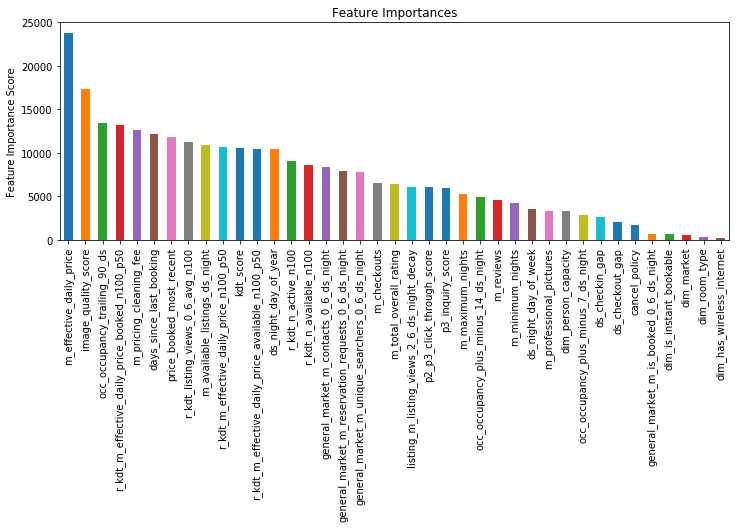

In [11]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 12, 4

def create_feature_map(file_name,features):
    outfile = open(file_name, 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train): %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy (Test): %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
create_feature_map('listingreq.fmap', stack_df)

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_inputs, train_output, test_inputs, test_output)

### Parameter Tuning


####  Tune max_depth and min_child_weight

Tuning tree related parameters, and it might take a while (~20min):

In [ ]:
param_test1 = {
 'max_depth': [4,7,10],
 'min_child_weight': [1,4,7]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_inputs, train_output)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

###### For saving your time, the output looks like:
```
([mean: 0.87861, std: 0.00157, params: {'max_depth': 4, 'min_child_weight': 1},
 mean: 0.87862, std: 0.00156, params: {'max_depth': 4, 'min_child_weight': 4}, 
mean: 0.87883, std: 0.00135, params: {'max_depth': 4, 'min_child_weight': 7}, 
mean: 0.90129, std: 0.00111, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.90073, std: 0.00122, params: {'max_depth': 7, 'min_child_weight': 4}, 
mean: 0.90003, std: 0.00130, params: {'max_depth': 7, 'min_child_weight': 7}, 
mean: 0.91802, std: 0.00075, params: {'max_depth': 10, 'min_child_weight': 1}, 
mean: 0.91539, std: 0.00069, params: {'max_depth': 10, 'min_child_weight': 4}, 
mean: 0.91413, std: 0.00114, params: {'max_depth': 10, 'min_child_weight': 7}], 
{'max_depth': 10, 'min_child_weight': 1}, 0.9180213075672359)
```

#### Tune gamma

Tuning split restrictions w/ updated `max_depth` and `min_child_weight`:

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,10,2)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_inputs, train_output)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
###### For saving your time, the output looks like:
```
[mean: 0.91802, std: 0.00075, params: {'gamma': 0.0}, 
mean: 0.91783, std: 0.00060, params: {'gamma': 0.2}, 
mean: 0.91827, std: 0.00081, params: {'gamma': 0.4}, 
mean: 0.91805, std: 0.00089, params: {'gamma': 0.6}, 
mean: 0.91786, std: 0.00086, params: {'gamma': 0.8}] 
{'gamma': 0.4} 0.9182724612977561
```

#### Tune subsample and colsample_bytree
Tuning feature samples related parameters with above optimal setting:

In [ ]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10,2)],
 'colsample_bytree':[i/10.0 for i in range(6,10,2)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=10,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_inputs, train_output)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
###### For saving your time, the output looks like:
```
[mean: 0.91585, std: 0.00114, params: {'colsample_bytree': 0.6, 'subsample': 0.6}, 
mean: 0.91825, std: 0.00058, params: {'colsample_bytree': 0.6, 'subsample': 0.8}, 
mean: 0.91992, std: 0.00087, params: {'colsample_bytree': 0.6, 'subsample': 1.0}, 
mean: 0.91589, std: 0.00125, params: {'colsample_bytree': 0.8, 'subsample': 0.6}, 
mean: 0.91827, std: 0.00081, params: {'colsample_bytree': 0.8, 'subsample': 0.8}, 
mean: 0.91914, std: 0.00085, params: {'colsample_bytree': 0.8, 'subsample': 1.0}, 
mean: 0.91548, std: 0.00140, params: {'colsample_bytree': 1.0, 'subsample': 0.6}, 
mean: 0.91703, std: 0.00062, params: {'colsample_bytree': 1.0, 'subsample': 0.8}, 
mean: 0.91725, std: 0.00088, params: {'colsample_bytree': 1.0, 'subsample': 1.0}] 
{'colsample_bytree': 0.6, 'subsample': 1.0} 0.9199152032945523
```

#### Tune Regularization Parameters
Tuning lambda to prevent overfitting:

In [ ]:
param_test4 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.4, subsample=1.0, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_inputs, train_output)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
###### For saving your time, the output looks like:
```
[mean: 0.91595, std: 0.00120, params: {'reg_lambda': 1e-05}, 
 mean: 0.91595, std: 0.00095, params: {'reg_lambda': 0.01}, 
 mean: 0.91525, std: 0.00079, params: {'reg_lambda': 0.1}, 
 mean: 0.91548, std: 0.00140, params: {'reg_lambda': 1}, 
 mean: 0.89979, std: 0.00111, params: {'reg_lambda': 100}] 
{'reg_lambda': 1e-05} 0.9159459589963668
```

#### Tuning Learning Rate

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=5000,
 max_depth=10,
 min_child_weight=1,
 gamma=0.4,
 subsample=1.0,
 colsample_bytree=0.6,
 reg_lambda=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_inputs, train_output, test_inputs, test_output)